# Modeling

Este documento contém toda a parte de modelagem do modelo preditivo, desde as modificações do data set até o armazenamento do melhor modelo criado:

1. [Importando dados](#Importando-dados)


2. [Pré processamento](#Pré-processamento)
    - Tratamento de dados nulos
    - Balanceamento da feature 'default'
    - Feature Engineering
    
    
3. [Processamento](#Processamento)
    - Analisando correlações para restringir colunas se necessário
    - Separação e normalização dos dados
    
    
4. [Modelagem (Com hyperpam. tuning)](#Modelagem-(Com-hyperpam.-tuning))
    - Usando Regressão Logística
    - Usando Support Vector Classifier
    - Usando árvore de decisão
    - Usando K Vizinhos Próximos (K nearest neighbors)
    - Usando SGDClassifier
    - Usando SGDClassifier
    

5. [Models Evaluation (avaliação dos modelos)](#Models-Evaluation-(avaliação-dos-modelos))
    - Precisão
    - Recall
    - F1-Score
    - Matriz de Confusão
    
    
6. [Salvando modelo](#Salvando-modelo)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Seed uzada para todos os randoms
seed = 7
np.random.seed(seed)

#Estilo dos gráficos
sns.set_style('whitegrid')

## Importando dados

In [2]:
df = pd.read_csv('../Dados/bankloans.csv')

In [3]:
df.query('default == 0')

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
5,41,2,5,5,25,10.2,0.392700,2.157300,0.0
6,39,1,20,9,67,30.6,3.833874,16.668126,0.0
...,...,...,...,...,...,...,...,...,...
694,48,2,6,1,66,12.1,2.315940,5.670060,0.0
696,29,2,6,4,21,11.5,0.369495,2.045505,0.0
697,33,1,15,3,32,7.6,0.491264,1.940736,0.0
698,45,1,19,22,77,8.4,2.302608,4.165392,0.0


In [4]:
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


## Pré processamento

### Tratamento de dados nulos

In [6]:
df.dropna(how='any', inplace=True)

### Balanceamento da feature 'default'

In [7]:
df['default'].value_counts(normalize=True)

0.0    0.738571
1.0    0.261429
Name: default, dtype: float64

In [8]:
df['default'].value_counts(normalize=False)

0.0    517
1.0    183
Name: default, dtype: int64

In [9]:
# Undersampling nos dados default == 0:
#    tamanho do df default == 0 se reduz a 1x do tamanho do df default == 1

i_zero = np.random.choice(df.query('default == 0').index.to_list(),
                          int(1*len(df.query('default == 1').index.to_list())))

df = pd.concat([df.query('default == 0').loc[i_zero], df.query('default == 1')], axis=0)

### Feature Engineering

In [10]:
# Extraindo colunas da feature categórica 'ed'
df['ed_1'] = df['ed'].apply(lambda x:1 if x==1 else 0)
df.drop('ed', axis=1, inplace=True)


# Guardando os dados de 'employ' em intervalos
employ_min = df['employ'].min()
employ_max = df['employ'].max()
bins = np.linspace(employ_min, employ_max, 4) #4 pontos -> três intervalos
group_names = [1, 2, 3]
df['employ'] = pd.cut(x=df['employ'], bins=bins, labels=group_names, include_lowest=True)

# Corrigindo desbalanceamento de 'employ'
df['employ_lvl_1'] = df['employ'].apply(lambda x:1 if x==1 else 0)
df.drop('employ', axis=1, inplace=True)


# Guardando os dados de 'address' em intervalos
address_min = df['address'].min()
address_max = df['address'].max()
bins = np.linspace(address_min, address_max, 4) #4 pontos -> três intervalos
group_names = [1, 2, 3]
df['address'] = pd.cut(x=df['address'], bins=bins, labels=group_names, include_lowest=True)

# Corrigindo desbalanceamento de 'address'
df['address_group_1'] = df['address'].apply(lambda x:1 if x==1 else 0)
df.drop('address', axis=1, inplace=True)

## Processamento

### Analisando correlações para restringir colunas se necessário

In [11]:
df.corr()['default'].apply(lambda x:x if x>=0 else -x).sort_values(ascending=False).to_frame()

,default
default,1.000000
debtinc,0.456738
creddebt,0.270505
employ_lvl_1,0.221249
address_group_1,0.220847
othdebt,0.212460
age,0.192695
ed_1,0.125691
income,0.057826


### Separação e normalização dos dados

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns={'default'})
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelagem (Com hyperpam. tuning)

In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

results = {}

### Usando Regressão Logística

In [14]:
from sklearn.linear_model import LogisticRegression

lr_model = BayesSearchCV(LogisticRegression(random_state=seed), 
                        {
                            'C':Real(1e-4, 1e2, prior='log-uniform')
                        },
                         cv=4,
                         random_state=seed,
                         n_iter=32
                        )

lr_model.fit(X_train, y_train)

y_hat = lr_model.predict(X_test)

results['LR'] = y_hat

print(lr_model.best_estimator_)

LogisticRegression(C=0.973829282440551, random_state=7)


### Usando Support Vector Classifier

In [15]:
from sklearn.svm import SVC

svc_model = BayesSearchCV(SVC(probability=True),
                          {
                             'C': Real(1e-4, 1e+3, prior='log-uniform'),
                             'gamma': Real(1e-4, 1e+1, prior='log-uniform'),
                             'degree': Integer(1,6),
                             'kernel': Categorical(['linear', 'poly', 'rbf']),
                          },
                          n_iter=30,
                          random_state=seed
                          )

svc_model.fit(X_train, y_train)

y_hat = svc_model.predict(X_test)

results['SVC'] = y_hat

print(svc_model.best_estimator_)

SVC(C=1000.0, degree=6, gamma=0.0001, probability=True)


### Usando árvore de decisão

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=seed)

tree_model.fit(X_train, y_train)

y_hat = tree_model.predict(X_test)

results['TREE'] = y_hat

### Usando K Vizinhos Próximos (K nearest neighbors)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = BayesSearchCV( KNeighborsClassifier(), 
                           {
                               'n_neighbors':Integer(1,10),
                               'weights': Categorical(['uniform', 'distance']) 
                           },
                           n_iter=32,
                           random_state=seed)

knn_model.fit(X_train, y_train)

y_hat = knn_model.predict(X_test)

results['KNN'] = y_hat

print(knn_model.best_estimator_)

C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\vinip\.conda\envs\DataScience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point befor

KNeighborsClassifier(n_neighbors=10, weights='distance')


### Usando Floresta Aleatória

In [18]:
from sklearn.ensemble import RandomForestClassifier


forest_model = BayesSearchCV(RandomForestClassifier(random_state=seed),
                             {
                                  'n_estimators': [5,20,50,100],
                                  'max_features': Categorical(['auto', 'sqrt']),
                                  'max_depth': Integer(10,120),
                                  'min_samples_split': Integer(2,30),
                                  'min_samples_leaf': Integer(1,5),
                                  'bootstrap': [True, False]
                             },
                             random_state=seed,
                             cv=4,
                             n_iter=32
                             )

forest_model.fit(X_train, y_train)

y_hat = forest_model.predict(X_test)

results['FOREST'] = y_hat

print(forest_model.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=22,
                       n_estimators=50, random_state=7)


## Models Evaluation (avaliação dos modelos)

Sabendo que o problema em questão é sobre análise de risco, entre os erros possíveis:
- I - Classificar um cliente como devedor sendo que ele não é (melhor erro possível, gera menos prejuízo para a empresa)
- II - Classificar um cliente como não devedor sendo que ele é (pior erro possível, gera mais prejuízo para a empresa)

Portanto, modelos que apresentem menor quantidade de erros do tipo II mencionado acima serão favorecidos na avaliação.

### Precisão

In [19]:
from sklearn.metrics import precision_score

print('Precisão de treino\n')
print('Logistic Regression: ', precision_score(y_true=y_train, y_pred=lr_model.predict(X_train)))
print('Support Vector Class.: ', precision_score(y_true=y_train, y_pred=svc_model.predict(X_train)))
print('Decision Tree Class.: ', precision_score(y_true=y_train, y_pred=tree_model.predict(X_train)))
print('K Nearest Neighbors: ', precision_score(y_true=y_train, y_pred=knn_model.predict(X_train)))
print('Random Forest Class.: ', precision_score(y_true=y_train, y_pred=forest_model.predict(X_train)))

print('\n\nPrecisão de teste\n')
print('Logistic Regression: ', precision_score(y_true=y_test, y_pred=results['LR']))
print('Support Vector Class.: ', precision_score(y_true=y_test, y_pred=results['SVC']))
print('Decision Tree Class.: ', precision_score(y_true=y_test, y_pred=results['TREE']))
print('K Nearest Neighbors: ', precision_score(y_true=y_test, y_pred=results['KNN']))
print('Random Forest Class.: ', precision_score(y_true=y_test, y_pred=results['FOREST']))

Precisão de treino

Logistic Regression:  0.7829457364341085
Support Vector Class.:  0.7903225806451613
Decision Tree Class.:  1.0
K Nearest Neighbors:  1.0
Random Forest Class.:  0.8571428571428571


Precisão de teste

Logistic Regression:  0.7903225806451613
Support Vector Class.:  0.7796610169491526
Decision Tree Class.:  0.7222222222222222
K Nearest Neighbors:  0.7857142857142857
Random Forest Class.:  0.8035714285714286


### Recall

In [20]:
from sklearn.metrics import recall_score

print('\n\nDados de treino')
print('Logistic Regression: ', recall_score(y_true=y_train, y_pred=lr_model.predict(X_train)))
print('Support Vector Class.: ', recall_score(y_true=y_train, y_pred=svc_model.predict(X_train)))
print('Decision Tree Class.: ', recall_score(y_true=y_train, y_pred=tree_model.predict(X_train)))
print('K Nearest Neighbors: ', recall_score(y_true=y_train, y_pred=knn_model.predict(X_train)))
print('Random Forest Class.: ', recall_score(y_true=y_train, y_pred=forest_model.predict(X_train)))

print('\n\nDados de teste')
print('Logistic Regression: ', recall_score(y_true=y_test, y_pred=results['LR']))
print('Support Vector Class.: ', recall_score(y_true=y_test, y_pred=results['SVC']))
print('Decision Tree Class.: ', recall_score(y_true=y_test, y_pred=results['TREE']))
print('K Nearest Neighbors: ', recall_score(y_true=y_test, y_pred=results['KNN']))
print('Random Forest Class.: ', recall_score(y_true=y_test, y_pred=results['FOREST']))



Dados de treino
Logistic Regression:  0.7829457364341085
Support Vector Class.:  0.7596899224806202
Decision Tree Class.:  1.0
K Nearest Neighbors:  1.0
Random Forest Class.:  0.8837209302325582


Dados de teste
Logistic Regression:  0.9074074074074074
Support Vector Class.:  0.8518518518518519
Decision Tree Class.:  0.7222222222222222
K Nearest Neighbors:  0.8148148148148148
Random Forest Class.:  0.8333333333333334


### F1-Score

In [21]:
from sklearn.metrics import f1_score

print('Logistic Regression: ', f1_score(y_true=y_test, y_pred=results['LR']))
print('Support Vector Class.: ', f1_score(y_true=y_test, y_pred=results['SVC']))
print('Decision Tree Class.: ', f1_score(y_true=y_test, y_pred=results['TREE']))
print('K Nearest Neighbors: ', f1_score(y_true=y_test, y_pred=results['KNN']))
print('Random Forest Class.: ', f1_score(y_true=y_test, y_pred=results['FOREST']))

Logistic Regression:  0.8448275862068966
Support Vector Class.:  0.8141592920353983
Decision Tree Class.:  0.7222222222222222
K Nearest Neighbors:  0.7999999999999999
Random Forest Class.:  0.8181818181818182


### Matriz de confusão

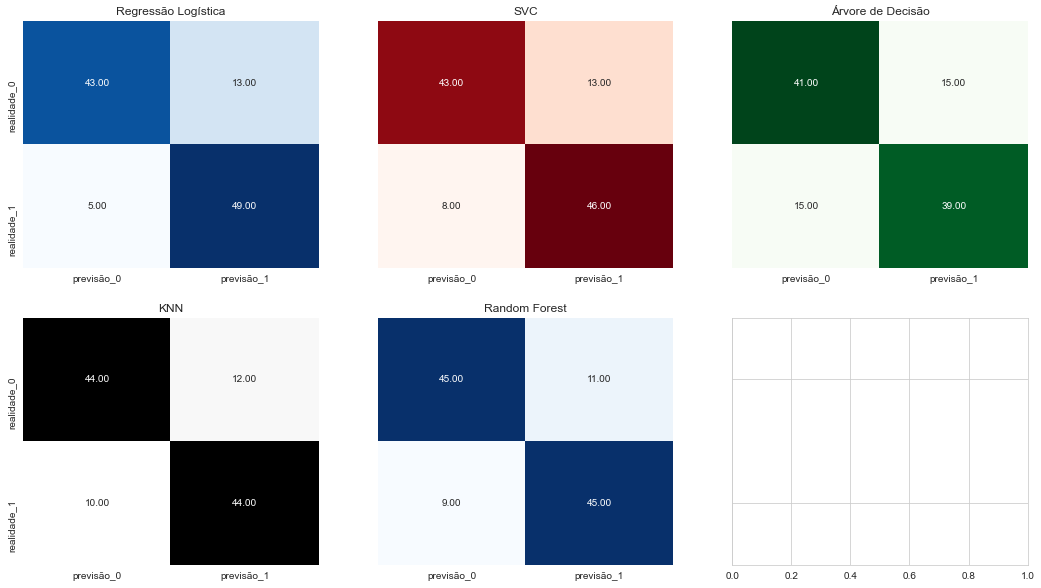

In [22]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 3, figsize=(18,10), sharey=True)

# Logistic Regression
ax[0][0].set_title('Regressão Logística')
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=results['LR']),
            ax=ax[0][0],
            fmt='.2f',
            cmap='Blues',
            annot=True,
            cbar=False,
            xticklabels=['previsão_0', 'previsão_1'],
            yticklabels=['realidade_0', 'realidade_1'])


# Support Vector Class.
ax[0][1].set_title('SVC')
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=results['SVC']),
            ax=ax[0][1],
            fmt='.2f',
            cmap='Reds',
            annot=True,
            cbar=False,
            xticklabels=['previsão_0', 'previsão_1'],
            yticklabels=['realidade_0', 'realidade_1'])


# Decision Tree Class.
ax[0][2].set_title('Árvore de Decisão')
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=results['TREE']),
            ax=ax[0][2],
            fmt='.2f',
            cmap='Greens',
            annot=True,
            cbar=False,
            xticklabels=['previsão_0', 'previsão_1'],
            yticklabels=['realidade_0', 'realidade_1'])


# K Nearest Neighbors
ax[1][0].set_title('KNN')
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=results['KNN']),
            ax=ax[1][0],
            fmt='.2f',
            cmap='Greys',
            annot=True,
            cbar=False,
            xticklabels=['previsão_0', 'previsão_1'],
            yticklabels=['realidade_0', 'realidade_1'])




# Random Forest Classifier
ax[1][1].set_title('Random Forest')
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=results['FOREST']),
            ax=ax[1][1],
            fmt='.2f',
            cmap='Blues',
            annot=True,
            cbar=False,
            xticklabels=['previsão_0', 'previsão_1'],
            yticklabels=['realidade_0', 'realidade_1'])


plt.savefig('../Imagens/Matrizes_confusão.png')
plt.show()

## Salvando modelo

In [24]:
import pickle

try:
    arq = open('../Modelos/modelo_classificacao_default.pk', 'wb')
    pickle.dump(lr_model, arq)
    arq.close()

except:
    print('Erro ao salvar modelo de classificação no arquivo especificado...')